In [5]:
from Environments import *

In [ ]:
class Settings:
    def __init__(self):
        self.road_function = sin(x)
        self.road_width    = 1
        self.road_length   = 10
        self.closed        = closed
        self.road_resulotion = 1000


In [ ]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(5):
    carenv.move(np.random.uniform(-.5, .5))
    distance, closest_x = roadenv.distance_road_center(carenv.x, carenv.y)
    distance, direction, out_of_road = roadenv.road_direction_and_terminal( distance, closest_x)
    if not  out_of_road:
        print(f"Distance: {distance}, Direction: {direction}, carenv.theta: {carenv.theta}, Out of road: {out_of_road}")
        print(f"                    , Direction: {abs(direction - carenv.theta)}")



Visualize(roadenv, carenv, settings)

In [ ]:
import math
import sympy as sp
import numpy as np
from scipy.optimize import minimize_scalar

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class Settings:
    def __init__(self):
        # road settings
        self.road_function = lambda x: 2*sp.sin(x)
        self.road_width    = 1
        self.road_length   = 15
        self.closed        = True
        self.road_resulotion = 1000

        # car settings

        # car initail position
        self.init_car_x = 0
        self.init_car_y = 0
        self.init_car_theta = 0
        self.init_car_speed = .2



class RoadEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = sp.Symbol('x')
        self.y = sp.sympify(self.settings.road_function(self.x))

    def get_road_limits(self):
        # Calculate the derivative of the road function
        dy_dx = sp.diff(self.y, self.x)

        # Calculate the normal vector
        normal_x = -dy_dx / sp.sqrt(1 + dy_dx ** 2)
        normal_y = 1 / sp.sqrt(1 + dy_dx ** 2)

        # Calculate the road limits
        half_width = self.settings.road_width / 2
        left_x = self.x + normal_x * half_width
        left_y = self.y + normal_y * half_width
        right_x = self.x - normal_x * half_width
        right_y = self.y - normal_y * half_width

        # Create lambda functions for the road limits
        road_limits = {
            'left': sp.lambdify(self.x, (left_x, left_y), 'numpy'),
            'right': sp.lambdify(self.x, (right_x, right_y), 'numpy'),
            'center': sp.lambdify(self.x, (self.x, self.y), 'numpy')
        }

        return road_limits
    
    
    
    
    def distance_road_center(self, x, y):
        # Define the road center function
        road_center = sp.lambdify(self.x, self.y, 'numpy')

        # Define a function to minimize (distance between point and road)
        def distance_func(t):
            return (t - x) ** 2 + (road_center(t) - y) ** 2

        # Find the closest point on the road
        result = minimize_scalar(distance_func, bounds=(0, self.settings.road_length), method='bounded')
        closest_x = result.x
        closest_y = road_center(closest_x)

        # Calculate the distance
        distance = np.sqrt((x - closest_x) ** 2 + (y - closest_y) ** 2)

        return distance, closest_x
    
    
    def road_direction_and_terminal(self, distance, closest_x):
        if distance > self.settings.road_width / 2:
            return None, None, None, True

        # Calculate the direction of the road at the closest point
        dy_dx = sp.diff(self.y, self.x)
        road_direction = sp.lambdify(self.x, dy_dx, 'numpy')
        direction = np.arctan(road_direction(closest_x))

        return distance,road_direction(closest_x), direction, False

class CarEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def car_reset():
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def move(self, steering_angle):
        # Update the car position
        self.x += self.speed * np.cos(self.theta)
        self.y += self.speed * np.sin(self.theta)
        self.theta = (self.theta +steering_angle) % (2 * np.pi)
        self.trejectory.append((self.x, self.y))


def Visualize(roadenv, carenv, settings):
    road_limits = roadenv.get_road_limits()

    # Generate x values for plotting
    x = np.linspace(0, settings.road_length, 1000)

    # Get road limits
    left_road_limit = road_limits['left'](x)
    right_road_limit = road_limits['right'](x)
    center_road_limits = road_limits['center'](x)

    # Plot the road with gray backround

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(left_road_limit[0], left_road_limit[1], '-', color='gold', label='Road edge')
    ax.plot(right_road_limit[0], right_road_limit[1], '-', color='gold')
    ax.plot(center_road_limits[0], center_road_limits[1], 'w--', label='Center line')


    ax.set_facecolor('gray')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Road Visualization')
    ax.legend()

    # Ensure the aspect ratio is equal
    ax.set_aspect('equal', 'box')

    # Plot the car as an arrow and the trejectory in red
    arrow_length = 0.3
    ax.arrow(carenv.x, carenv.y, arrow_length*np.cos(carenv.theta), arrow_length*np.sin(carenv.theta), head_width=0.2, head_length=0.1, fc='r', ec='r', label='Car')
    ax.plot(*zip(*carenv.trejectory), 'r--', label='Trejectory')



    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(5):
    carenv.move(np.random.uniform(-.5, .5))
    distance, closest_x = roadenv.distance_road_center(carenv.x, carenv.y)
    distance,road_direction, direction, out_of_road = roadenv.road_direction_and_terminal( distance, closest_x)
    if not  out_of_road:
        print(f"Distance: {distance},road_direction ={road_direction}, Direction: {direction}, carenv.theta: {carenv.theta}, Out of road: {out_of_road}")
        print(f"                    , Direction: {abs(direction - carenv.theta)}")



Visualize(roadenv, carenv, settings)

In [60]:
import math
import sympy as sp
import numpy as np
from scipy.optimize import minimize_scalar

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class Settings:
    def __init__(self):
        # road settings
        self.road_function = lambda x: 2*sp.sin(x)
        self.road_width    = 1
        self.road_length   = 15
        self.closed        = True
        self.road_resulotion = 1000

        # car settings

        # car initail position
        self.init_car_x = 0
        self.init_car_y = 0
        self.init_car_theta = 0
        self.init_car_speed = .2



class RoadEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = sp.Symbol('x')
        self.y = sp.sympify(self.settings.road_function(self.x))

    def get_road_limits(self):
        # Calculate the derivative of the road function
        dy_dx = sp.diff(self.y, self.x)

        # Calculate the normal vector
        normal_x = -dy_dx / sp.sqrt(1 + dy_dx ** 2)
        normal_y = 1 / sp.sqrt(1 + dy_dx ** 2)

        # Calculate the road limits
        half_width = self.settings.road_width / 2
        left_x = self.x + normal_x * half_width
        left_y = self.y + normal_y * half_width
        right_x = self.x - normal_x * half_width
        right_y = self.y - normal_y * half_width

        # Create lambda functions for the road limits
        road_limits = {
            'left': sp.lambdify(self.x, (left_x, left_y), 'numpy'),
            'right': sp.lambdify(self.x, (right_x, right_y), 'numpy'),
            'center': sp.lambdify(self.x, (self.x, self.y), 'numpy')
        }

        return road_limits
    
    
    
    
    def distance_road_center(self, x, y):
        # Define the road center function
        road_center = sp.lambdify(self.x, self.y, 'numpy')

        # Define a function to minimize (distance between point and road)
        def distance_func(t):
            return (t - x) ** 2 + (road_center(t) - y) ** 2

        # Find the closest point on the road
        result = minimize_scalar(distance_func, bounds=(0, self.settings.road_length), method='bounded')
        closest_x = result.x
        closest_y = road_center(closest_x)

        # Calculate the distance
        distance = np.sqrt((x - closest_x) ** 2 + (y - closest_y) ** 2)

        return distance, closest_x
    
    
    def road_direction_and_terminal(self, distance, closest_x):
        if distance > self.settings.road_width / 2:
            return None, None, None, True

        # Calculate the direction of the road at the closest point
        dy_dx = sp.diff(self.y, self.x)
        road_direction = sp.lambdify(self.x, dy_dx, 'numpy')
        direction = np.arctan(road_direction(closest_x))

        return distance,road_direction(closest_x), direction, False

class CarEnv:
    def __init__(self, settings):
        self.settings = settings
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def car_reset():
        self.x = settings.init_car_x
        self.y = settings.init_car_y
        self.theta = settings.init_car_theta
        self.speed = settings.init_car_speed
        self.trejectory = [(self.x, self.y)]

    def move(self, steering_angle):
        # Update the car position
        self.x += self.speed * np.cos(self.theta)
        self.y += self.speed * np.sin(self.theta)
        self.theta = (self.theta +steering_angle) % (2 * np.pi)
        self.trejectory.append((self.x, self.y))


def Visualize(roadenv, carenv, settings):
    road_limits = roadenv.get_road_limits()

    # Generate x values for plotting
    x = np.linspace(0, settings.road_length, 1000)

    # Get road limits
    left_road_limit = road_limits['left'](x)
    right_road_limit = road_limits['right'](x)
    center_road_limits = road_limits['center'](x)

    # Plot the road with gray backround

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(left_road_limit[0], left_road_limit[1], '-', color='gold', label='Road edge')
    ax.plot(right_road_limit[0], right_road_limit[1], '-', color='gold')
    ax.plot(center_road_limits[0], center_road_limits[1], 'w--', label='Center line')


    ax.set_facecolor('gray')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Road Visualization')
    ax.legend()

    # Ensure the aspect ratio is equal
    ax.set_aspect('equal', 'box')

    # Plot the car as an arrow and the trejectory in red
    arrow_length = 0.3
    ax.arrow(carenv.x, carenv.y, arrow_length*np.cos(carenv.theta), arrow_length*np.sin(carenv.theta), head_width=0.2, head_length=0.1, fc='r', ec='r', label='Car')
    ax.plot(*zip(*carenv.trejectory), 'r--', label='Trejectory')



    ax.grid(True)
    plt.tight_layout()
    plt.show()


Distance: 0.17887588310957045,road_direction =1.9983974876916475, Direction: 1.1068280097679846, carenv.theta: 6.1899676781075215, Out of road: False
                    , Direction: 5.083139668339537
Distance: 0.36526296051954116,road_direction =1.9947311524101083, Direction: 1.106092723117805, carenv.theta: 0.32115481451758754, Out of road: False
                    , Direction: 0.7849379086002175


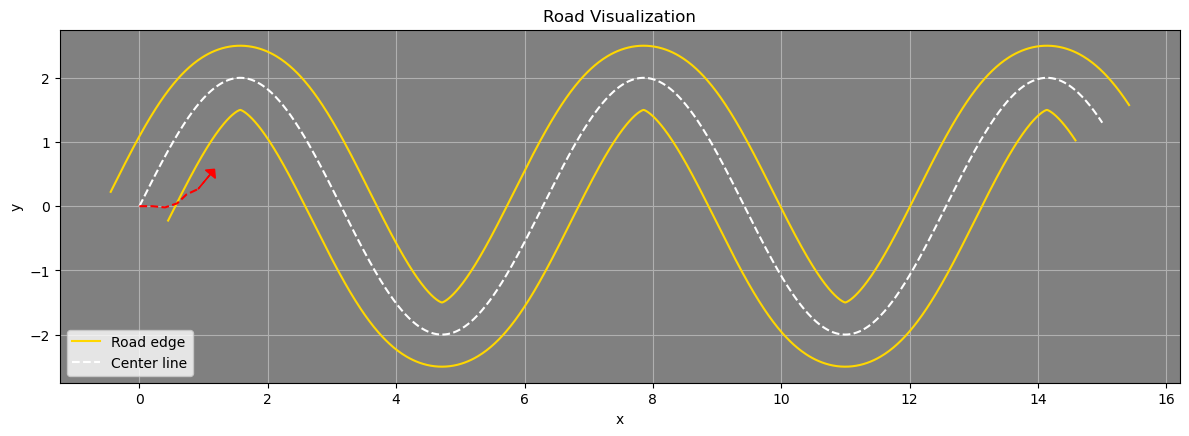

In [62]:
settings = Settings()
roadenv = RoadEnv(settings)
carenv = CarEnv(settings)
# move the car
for i in range(5):
    carenv.move(np.random.uniform(-.5, .5))
    distance, closest_x = roadenv.distance_road_center(carenv.x, carenv.y)
    distance,road_direction, direction, out_of_road = roadenv.road_direction_and_terminal( distance, closest_x)
    if not  out_of_road:
        print(f"Distance: {distance},road_direction ={road_direction}, Direction: {direction}, carenv.theta: {carenv.theta}, Out of road: {out_of_road}")
        print(f"                    , Direction: {abs(direction - carenv.theta)}")



Visualize(roadenv, carenv, settings)